<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
</center>
<center>Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий

# <center>  Capstone проект №1. Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. Задание имеет вид Peer-Review, так что творчество здесь активно приветствуется. Если задействуете IPython-виджеты, библиотеку Plotly, анимации и прочий интерактив, всем от этого будет только лучше.

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



## Часть 1. Построение признаков

In [1]:
from __future__ import division #, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = 'C:\Users\Olga\Documents\pr1\data' 

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [3]:
# Для каждого файла создаем список - последовательность id посещенных сайтов и дополняем ее нужным количеством нулей.
# Далее в цикле создаем строки матрицы и затем соединяем получившиеся блоки от разных файлов функцией np.vstack
import re
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                                    session_length, window_size):
    train_set_fe=np.array([])
    
    with open(site_freq_path, 'rb') as f: sites_dict = pickle.load(f)
    for file in glob(path_to_csv_files):
        s=session_length
        w=window_size
        u_id = int(re.findall('\d{4}', file)[0])
        user=pd.read_csv(file, parse_dates=['timestamp'])
        l=[]
        for site in user['site']: l.append(sites_dict[site][0])
        ll=len(l)
        sessions=[]
        for i in xrange(0, ll , w):
            session=(l+[0]*(s-ll%w)*np.sign(ll%w)+[0]*(s-w)*np.sign(1-ll%w))[i:i+s]
            sessions.append(session+[(user['timestamp'][min(i+s-1, ll-1)]-user['timestamp'][i]).seconds,
                                     len(set(session)-{0}),user['timestamp'][i].hour, user['timestamp'][i].dayofweek, u_id])            
        
        if len(train_set_fe)==0: train_set_fe=np.array(sessions)            
        else: train_set_fe=np.vstack((train_set_fe,np.array(sessions))) 
        ret=pd.DataFrame.from_records(train_set_fe)
        ret.columns=feature_names
    return ret

**Проверим функцию на игрушечном примере.**

In [29]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'user_id']
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '3users\\*'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10, window_size=10)

In [103]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,start_hour,day_of_week,user_id
0,1,2,2,3,2,4,5,6,7,8,7998,8,9,4,1
1,1,4,4,4,0,0,0,0,0,0,60,2,12,4,1
2,1,2,9,9,2,0,0,0,0,0,7935,3,9,4,2
3,10,4,2,4,2,4,4,6,11,10,7998,5,9,4,3
4,10,4,2,0,0,0,0,0,0,0,1471,3,12,4,3


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [30]:
%%time
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '10users\\*'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'),
                  feature_names=feature_names, session_length=10, window_size=10)

Wall time: 7.72 s


In [105]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,start_hour,day_of_week,user_id
0,1,2,3,4,3,3,4,3,5,3,33,5,8,4,31
1,6,7,8,9,3,10,11,12,13,14,284,10,8,4,31
2,14,4,14,14,15,16,6,17,18,14,258,7,8,4,31
3,19,20,19,14,14,14,14,21,22,23,30,6,8,4,31
4,24,14,15,25,26,27,28,29,30,29,6,9,8,4,31


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [118]:
%%time
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '150users\\*'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_150users.pkl'),
                  feature_names=feature_names, session_length=10, window_size=10)

Wall time: 2min 50s


**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [119]:
new_features_10users = train_data_10users[['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']]
new_features_150users = train_data_150users[['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']]

In [111]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

## Часть 2. Визуальный анализ данных

**Забавы ради, потехи для дадим пользователям имена и ассоциируем с ними цвета.**

In [31]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['user_id'] = train_data_10users['user_id'].map(id_name_dict)

In [32]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

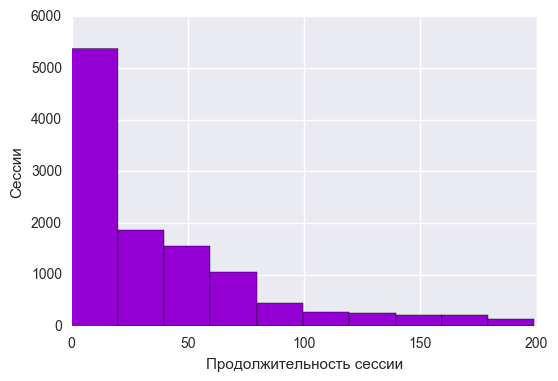

In [186]:
plt.hist(train_data_10users['session_timespan'][train_data_10users.session_timespan<200], color='darkviolet')
plt.xlabel(u'Продолжительность сессии')
plt.ylabel(u'Сессии')

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

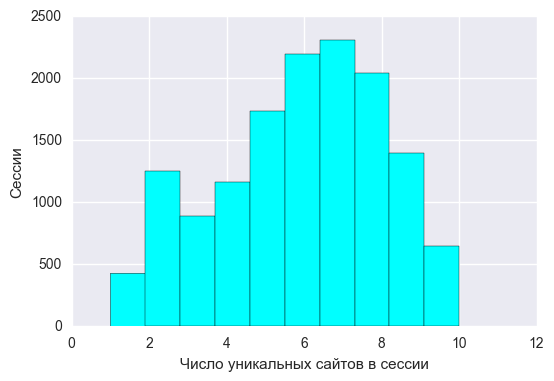

In [183]:
plt.hist(train_data_10users['#unique_sites'], color='aqua')
plt.xlabel(u'Число уникальных сайтов в сессии')
plt.ylabel(u'Сессии')

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

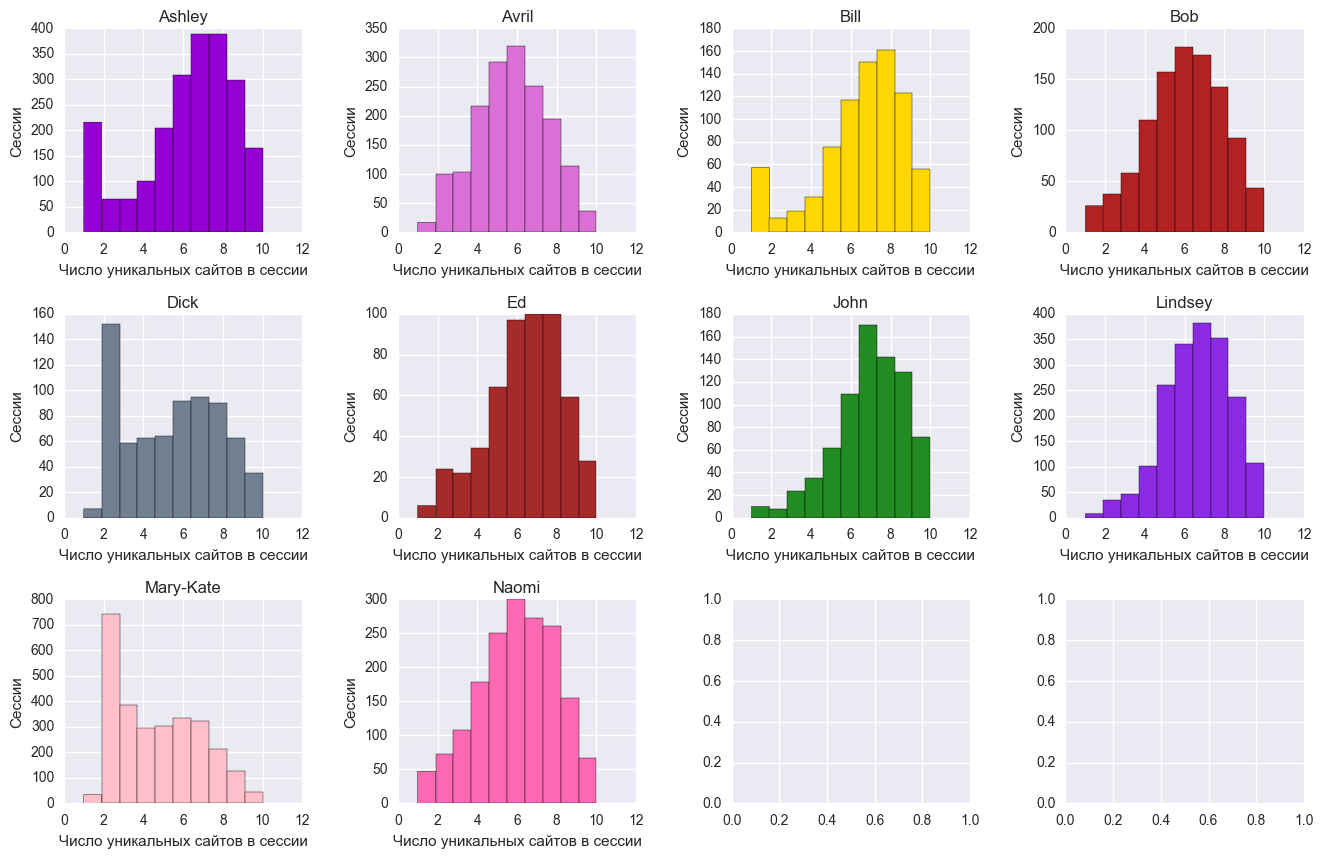

In [177]:
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
fig.subplots_adjust(wspace=0.4, hspace=0.4)
# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'user_id')):
    axx=ax[idx//4, idx%4]
    axx.hist(sub_df['#unique_sites'], color=color_dic[user])
    axx.set_title(user)
    axx.set_xlabel(u'Число уникальных сайтов в сессии')
    axx.set_ylabel(u'Сессии')
plt.show()

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

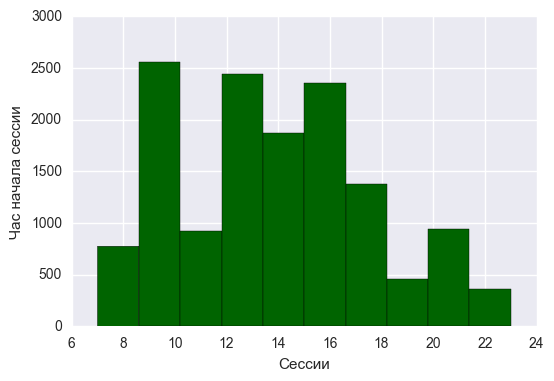

In [189]:
plt.hist(train_data_10users['start_hour'], color='darkgreen')
plt.xlabel(u'Сессии')
plt.ylabel(u'Час начала сессии')

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

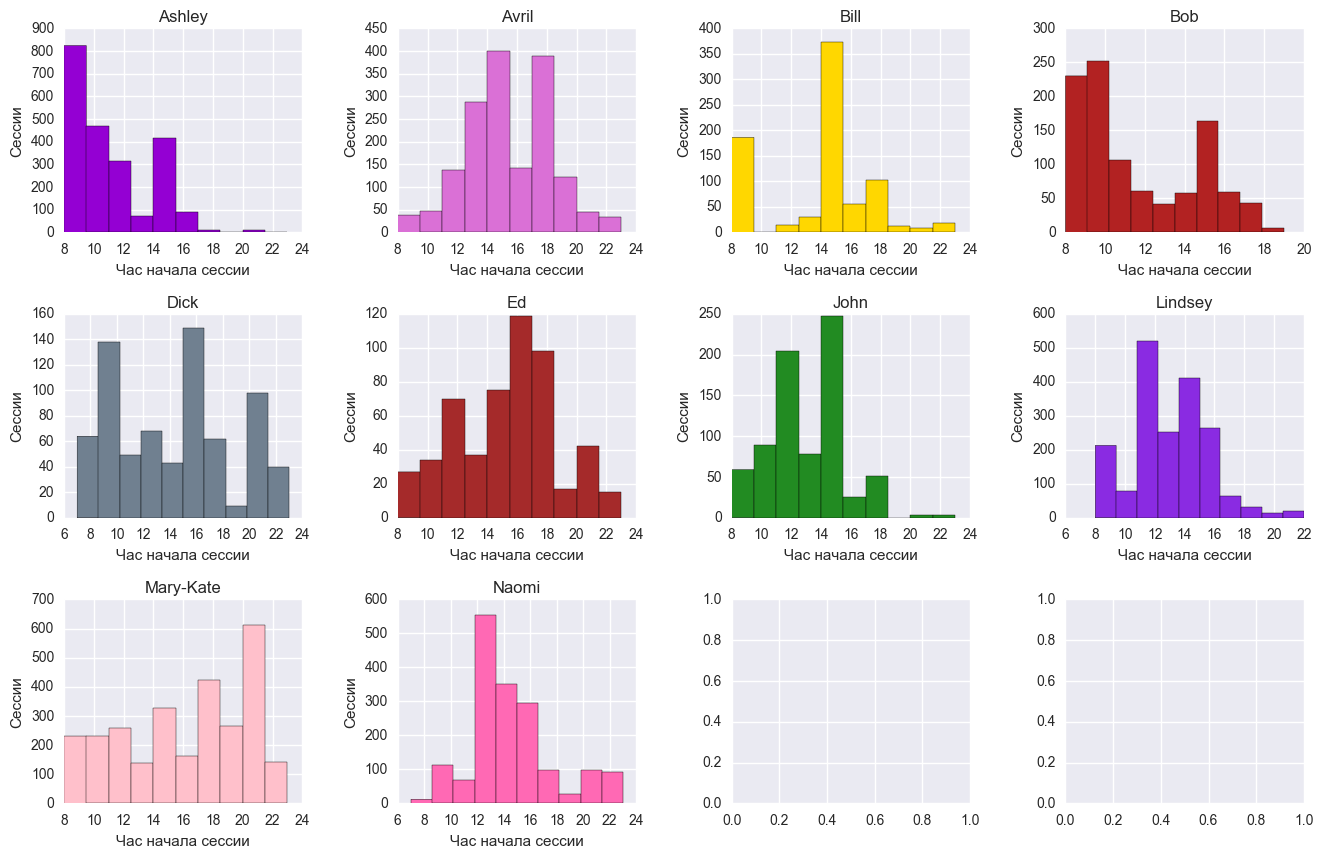

In [178]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
fig.subplots_adjust(wspace=0.4, hspace=0.4)
# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'user_id')):
    axx=axes[idx//4, idx%4]
    axx.hist(sub_df['start_hour'], color=color_dic[user])
    axx.set_title(user)
    axx.set_xlabel(u'Час начала сессии')
    axx.set_ylabel(u'Сессии')
plt.show()

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

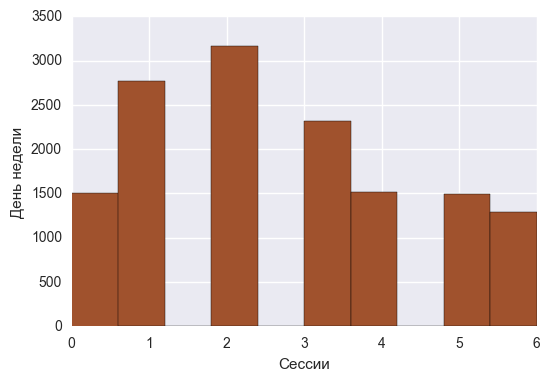

In [194]:
plt.hist(train_data_10users['day_of_week'], color='sienna')
plt.xlabel(u'Сессии')
plt.ylabel(u'День недели')

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

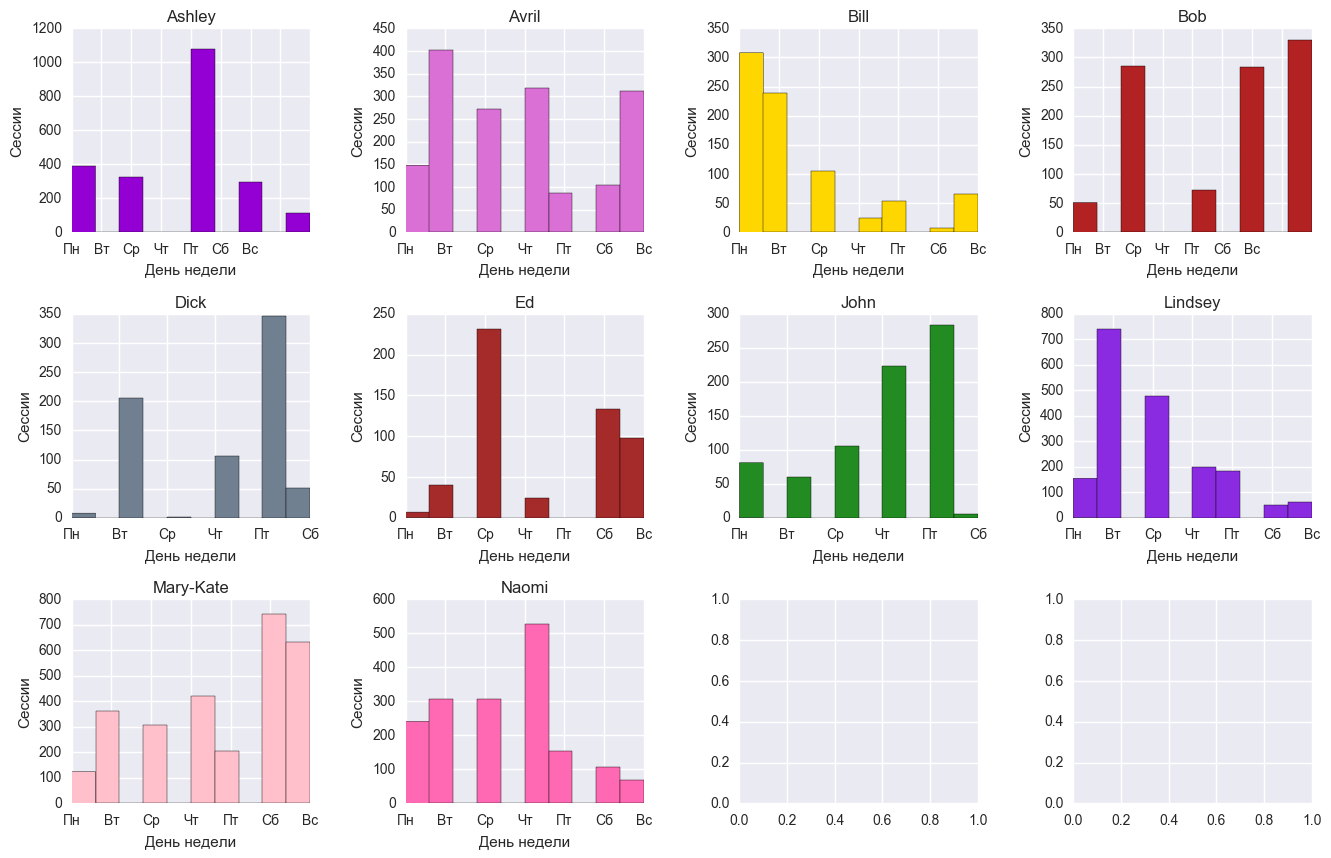

In [181]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
fig.subplots_adjust(wspace=0.4, hspace=0.4)
xlabels=[u'Пн', u'Вт', u'Ср', u'Чт', u'Пт', u'Сб', u'Вс']
# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'user_id')):
    axx=axes[idx//4, idx%4]
    axx.hist(sub_df['day_of_week'], color=color_dic[user])
    axx.set_title(user)
    axx.set_xlabel(u'День недели')
    axx.set_ylabel(u'Сессии')
    axx.set_xticklabels(xlabels)
plt.show()

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

Mary-Kate все выходные сидит в интернете, чаще всего просматривает одновременно пару сайтов 
Ashley обычно просматривает либо пару сайтов, либо как у всех 6-8. в основном пользуется интернетом по будням с 8 до 18.00. можно предположить что это рабочий компьютер. 
Lindsey пользуется интернетом в рабочее время, выходные проводит не за компьютером. 
Naomi пользуется интернетом довольно равномерно ничего примечательного сказать нельзя. 
Avril пользуется интернетом довольно равномерно ничего примечательного сказать нельзя. 
Bob похож на пользователя Ashley.
Bill пользуется интернетом в рабочие часы мало. Можно предположить что по работе интернет не нужен. в выходные тоже отдыхает вдали от комрьютера
John похож на пользователя Ashley.  
Dick может просидеть за компьютером весь день, по пнд и воскр компьютером не пользуется. часто сидит в режиме просмотра пары сайтов. 
Ed пользуется интернетом довольно равномерно. Не пользуется интернетом в пятницу.

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [5]:
with open(os.path.join(PATH_TO_DATA,'site_freq_10users.pkl'), 'rb') as f: site_freq_10users = pickle.load(f)

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [6]:
top10_freqs = map(lambda x: x[1][1], sorted(site_freq_10users.items(), key=lambda (k, v): v[1], reverse=True)[:10])
top10_sites = map(lambda x: x[0], sorted(site_freq_10users.items(), key=lambda (k, v): v[1], reverse=True)[:10])

**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

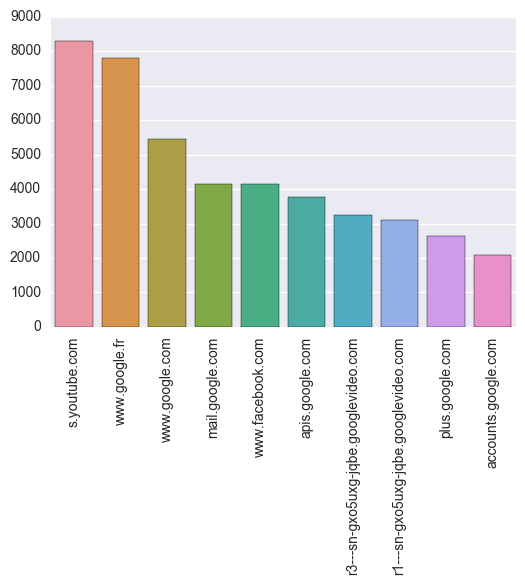

In [244]:
g=sns.barplot(y=top10_freqs, x=top10_sites)
for item in g.get_xticklabels():
    item.set_rotation(90)

## Часть 3. Проверка построенных признаков
Эта часть скорее техническая, смысл ее – убедиться, что мы все одинаково создали признаки *session_timespan, #unique_sites, start_hour* и *day_of_week*.

**10. Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [249]:
new_features_10users['session_timespan'].median(axis=0)

37.0

**11. Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [250]:
new_features_10users['day_of_week'].median(axis=0)

2.0

**12. Выведите медианный час начала сессии для сессий 150 пользователей.**

In [251]:
new_features_150users['start_hour'].median(axis=0)

13.0

**13. Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [252]:
new_features_150users['#unique_sites'].median(axis=0)

7.0

## Часть 4. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

Возьмем в качестве новых признаков индикаторы посещения непопулярных сайтов. Чтобы признаки действительно характеризовали пользователей, отсеем совсем случайные единичные сайты и будем смотреть только сайты, частота появления которых больше 20.

In [164]:
import copy
def feature_engineering(path_to_csv_files, site_freq_path, session_length=10):
    fe=np.array([])
    with open(site_freq_path, 'rb') as f: sites_dict = pickle.load(f)
    sites_dict1=copy.deepcopy(sites_dict)
    for (k,v) in sites_dict1.items():
        if v[1]<20: del sites_dict1[k]
        else:continue
    for file in glob(path_to_csv_files):
        top30_sites=map(lambda x: x[0], sorted(sites_dict1.items(), key=lambda (k, v): v[1], reverse=False)[:30])
        top30_sites_id=map(lambda x: x[1][0], sorted(sites_dict1.items(), key=lambda (k, v): v[1], reverse=False)[:30])
        s=session_length
        u_id = int(re.findall('\d{4}', file)[0])
        user=pd.read_csv(file, parse_dates=['timestamp'])
        l=[]
        for site in user['site']: l.append(sites_dict[site][0])
        ll=len(l)
        sessions=[]
        for i in xrange(0, ll , s):
            session=[int(j in (l+[0]*(s-ll%s)*np.sign(ll%s))[i:i+s]) for j in top30_sites_id]+[u_id]
            sessions.append(session)     
     
        if len(fe)==0: fe=np.array(sessions)            
        else: fe=np.vstack((fe,np.array(sessions))) 
        f_eng=pd.DataFrame.from_records(fe)   
        f_eng.columns= top30_sites+['user_id']
    return f_eng

In [165]:
new_features_10users1 = feature_engineering(os.path.join(PATH_TO_DATA,'10users\\*'),  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'), session_length=10)

In [166]:
new_features_150users1 = feature_engineering(os.path.join(PATH_TO_DATA,'150users\\*'),  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_150users.pkl'), session_length=10)

**14. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

Нарисуем график, где для каждого из наших 30 сайтов, укажем в каком кол-ве сессий он встречается. потом сделаем то же самое по пользователям. 

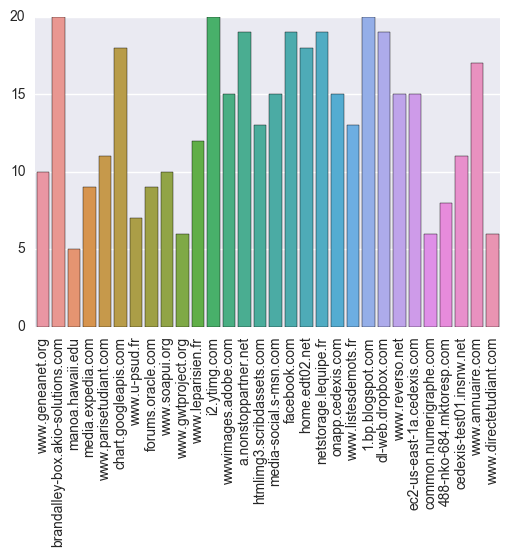

In [167]:
g=sns.barplot(y=new_features_10users1.iloc[:,:-1].sum(axis=0), x=new_features_10users1.columns[:-1])
for item in g.get_xticklabels():
    item.set_rotation(90)

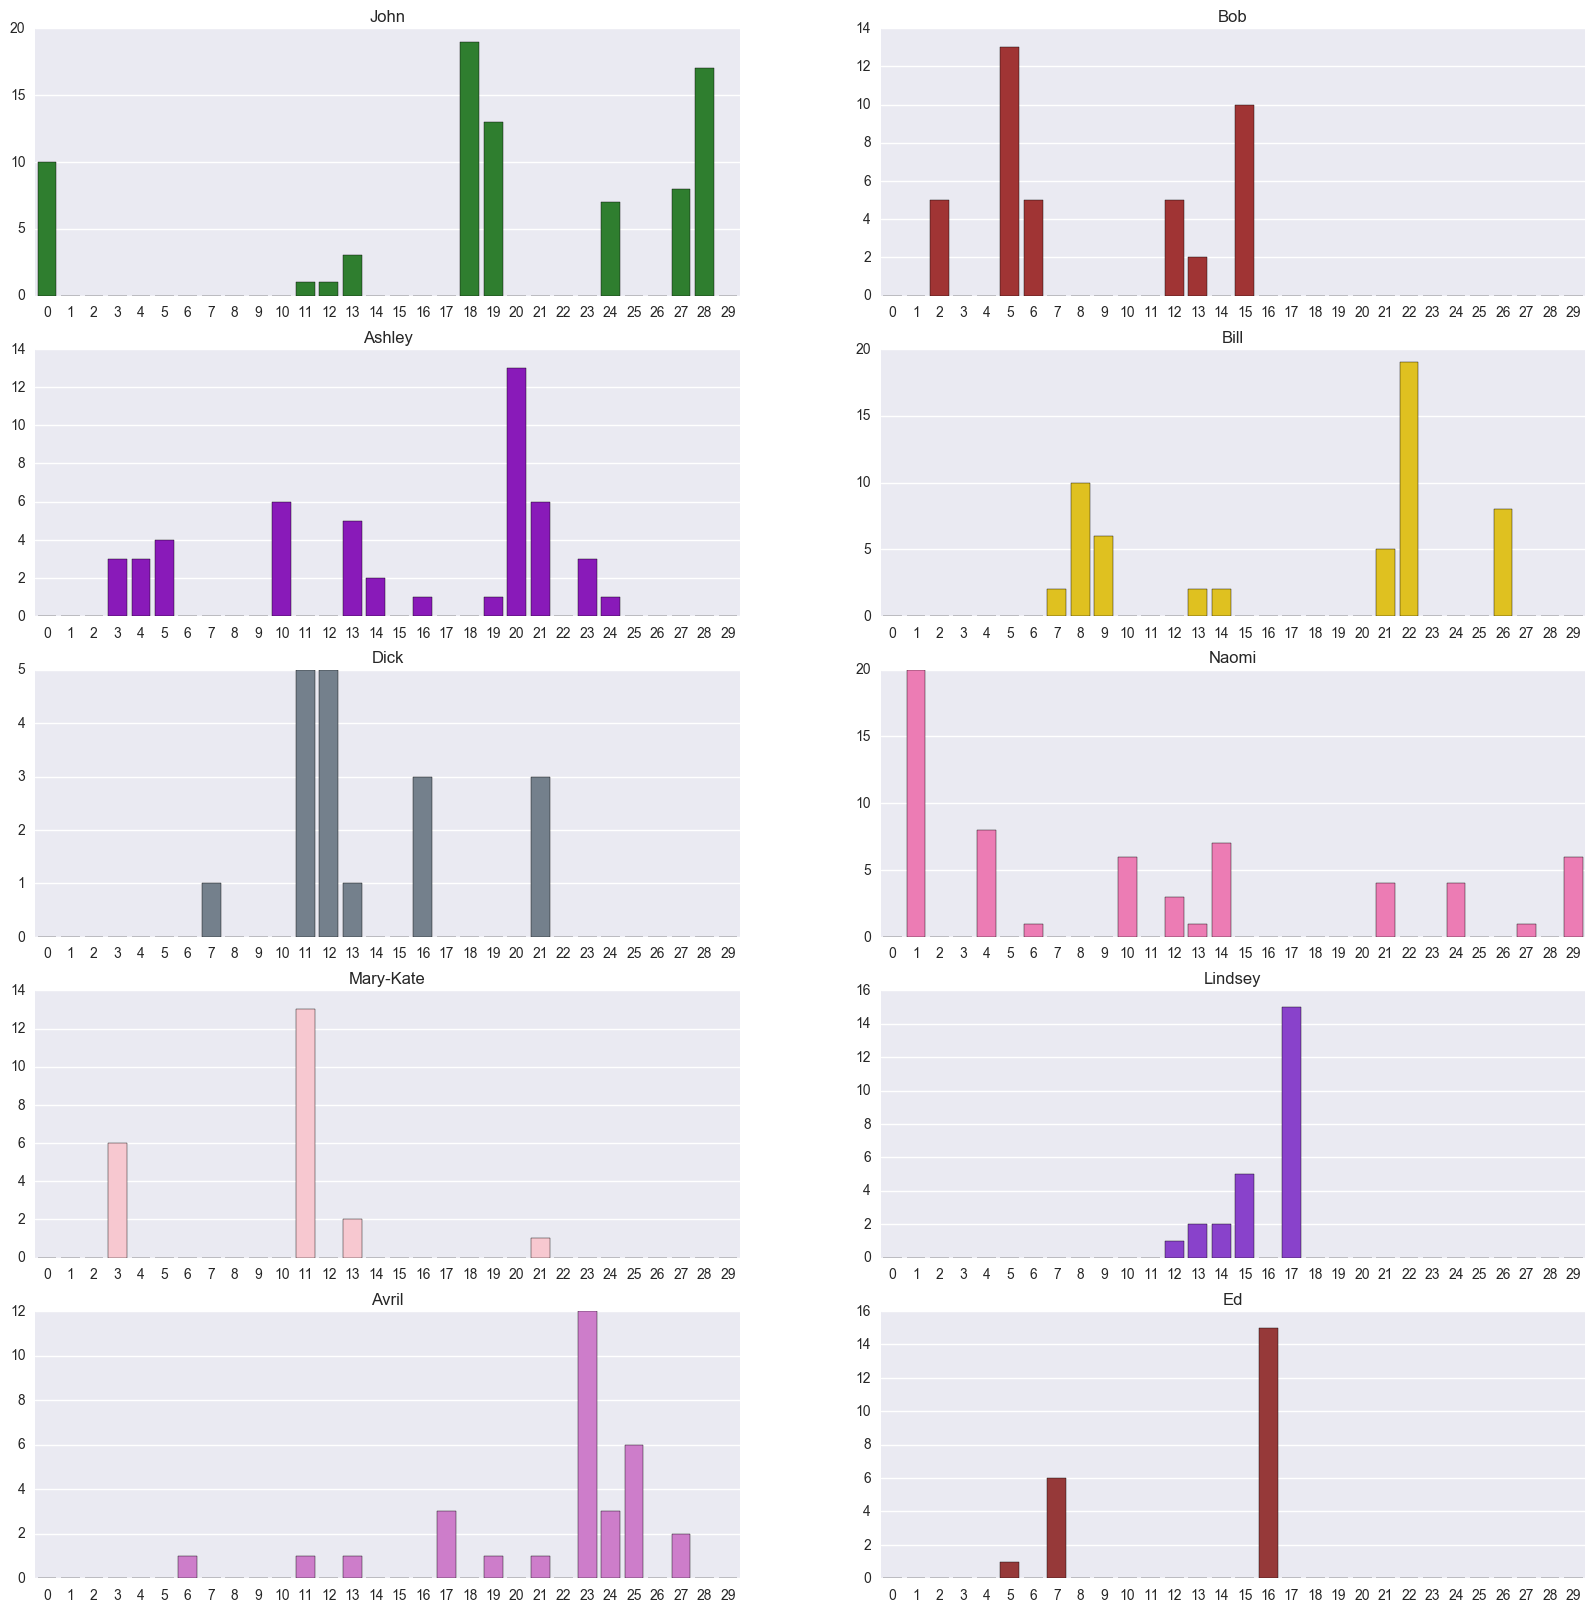

In [168]:
fig, axes = plt.subplots(5, 2, figsize=(20, 20))
for idx, (user, sub_df) in  enumerate(pd.groupby(new_features_10users1, 'user_id')):
    g=sns.barplot(y=sub_df.iloc[:,:-1].sum(axis=0), x=range(30), color=color_dic[id_name_dict[user]], ax=axes[idx // 2, idx % 2])
    g.set_title(id_name_dict[user])

Получилось неплохо. Пользователи имеют непохожие профили по данным признакам.

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [169]:
selected_features_10users = new_features_10users1.join(new_features_10users)
selected_features_150users = new_features_150users1.join(new_features_150users)

In [170]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)

## Критерии оценки работы:
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Правильно ли посчитана медианная продолжительность сессий в п. 10? (max. 3 балла)
- Правильно ли посчитан медианный день недели начала сессии в п. 11? (max. 3 балла)
- Правильно ли посчитан медианный час начала сессии в п. 12? (max. 3 балла)
- Правильно ли посчитано медианное значение числа уникальных сайтов в сессиях 150 пользователей п. 13? (max. 3 балла)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

## Пути улучшения
7 неделя посвящена общему описанию проекта (`html`, `ipynb` или `pdf`) и взаимному оцениванию. Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящие статьи по этому ремеслу – [раз](https://habrahabr.ru/post/308162/) и  [два](https://habrahabr.ru/company/ods/blog/323210/))
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями типа [Multicore-TSNE](https://github.com/DmitryUlyanov/Multicore-TSNE), не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

На следующей неделе мы наконец приступим к обучению моделей классификации. 